# Machine Learning Engineer Nanodegree
---
## Capstone Project: Anomaly Detection
---

Luis Chapa

June 28 th, 2018

### I. Intro

---
**Project Overview**

The Bank is in the way to search for protection to their clients against fraud operations. The most common operations they provide to their clients are: loans, payment-orders and transactions.

The Bank managers has shared an anonymized dataset with the Manchine Learning Team. Which includes information for those operations as well as their clients geography location and type of credit cards.

**Problem Statement**

So far, The Bank managers have not registered fraud operations. It means that there is no a **ground truth** yet. We were asked to help them in determine an **novelty threshold** in order to start identifying anomalies and/or novelties (outliers) in the dataset.

Because there is no ground truth already recorded, the solution to their problem is going to be an Unsupervised Feature Learning using two diferent approaches. Both approaches is going to be using reconstructing errors as decision parameter for classifying each data point as **novelty** or **normal** point.

By identifying novelties, The Bank managers are able to take actions on those outstanding operations, then validate the operation and label as fraud or not. Once the labeled dataset migth be populated the machine learning algorithms could be updated and retrained, but that is part of a diferent project, so far the threshold is needed.

**Metrics**

In this project, we will be determining the **novelty threshold**  as follows: 

1. Benchmark Model: 
$$ T = \lambda * max(distance(\forall_x, \forall_c)$$

$$ max(distance(x, \forall_c))\underset{False}{\overset{True}{\gtrless}} T$$

The threshold $T$ is determined by the max distance of each data point against each center of the clusters, then this number is reduced by a factor $\lambda$ in order to catch outstanding points in regards to the cluster centers. Once the threshold $T$ is calculated, each data point is labeled as novelty or normal accordingly if it is beyond this threshold in regards of the max distance to each center.

>**Note:**: In the proposal, we selected a Silhouette Score, however this score is calculated for all points. Instead of that joining score we determined a metric that could be calculated for each point individually.

2. Solution Model:

$$ T = \lambda * max(distance(f(x), h(r))$$

$$ distance(f(x), h(r)) \underset{False}{\overset{True}{\gtrless}} T $$

In this model, the threshold $T$ is calculated by taking the max distance (loss) in between the original point and the reconstructed by the autoencoder. 

---

The $distance$ function, used in both models is the Euclidean Distance between two multidimensional points.

### 2. Data Collect
---
The Bank managers has provided us a normalized and anonymized database to train the models on.

> For the porpuse of this Nanodegree Capstone Project, this dataset was downloaded from:  
lpetrocelli/1999 Czech Financial Dataset - Real Anonymized Transactions
Updated Jun 1, 2017
Version: d10118e4
Public Domain License
https://data.world/lpetrocelli/czech-financial-dataset-real-anonymized-transactions.

This section will load the dataset and display the count of the records and columns for each one of the tables. 


In [1]:
import numpy as np
import sklearn
import pandas as pd
import keras
import sys

import matplotlib.pyplot as plt
from IPython.display import display

# Pretty display for notebooks
%matplotlib inline

tables = ["account","client","disp","loan","trans","card","district","order"]

#Data set column names for each table accordingly to the csv files.
account_cols = ["account_id","district_id","frequency","date"]
client_cols = ["client_id","birth_number","district_id"]
disp_cols = ["disp_id","client_id","account_id","type"]
loan_cols = ["loan_id","account_id","date","amount","duration","payments","status"]
trans_cols = ["trans_id","account_id","date","type","operation","amount","balance","k_symbol","bank","account"]
card_cols = ["card_id","disp_id","type","issued"]
district_cols = ["A1","A2","A3","A4","A5","A6","A7","A8","A9","A10","A11","A12","A13","A14","A15","A16"]
order_cols = ["order_id","account_id","bank_to","account_to","amount","k_symbol"]

#Load each csv file into a pandas dataframe.
account = pd.read_csv('bank_data/account.csv', sep=';')
client = pd.read_csv('bank_data/client.csv', sep=';')
disp = pd.read_csv('bank_data/disp.csv', sep=';')
loan = pd.read_csv('bank_data/loan.csv', sep=';')
trans = pd.read_csv('bank_data/trans.csv', sep=';')
card = pd.read_csv('bank_data/card.csv', sep=';')
districts = pd.read_csv('bank_data/district.csv', sep=';')
order = pd.read_csv('bank_data/order.csv', sep=';')

#Display how many records each one of the tables has.
print("Account table has {} records and {} columns".format(account.shape[0],account.shape[1]))
print("Client table has {} records and {} columns".format(client.shape[0],client.shape[1]))
print("Loan table has {} records and {} columns".format(loan.shape[0],loan.shape[1]))
print("Trans table has {} records and {} columns".format(trans.shape[0],trans.shape[1]))
print("Order table has {} records and {} columns".format(order.shape[0],order.shape[1]))
print("Districts has {} records and {} columns".format(districts.shape[0],districts.shape[1]))
print("Cards has {} records and {} columns".format(card.shape[0],card.shape[1]))
print("Disp has {} records and {} columns".format(disp.shape[0],disp.shape[1]))


Using TensorFlow backend.


Account table has 4500 records and 4 columns
Client table has 5369 records and 3 columns
Loan table has 682 records and 7 columns
Trans table has 1056320 records and 10 columns
Order table has 6471 records and 6 columns
Districts has 77 records and 16 columns
Cards has 892 records and 4 columns
Disp has 5369 records and 4 columns


/Users/luischapa/anaconda2/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The data base has the following tables, each one of them is relevant to describe the behavior of the customers of The Bank, in order to detect those data points that outstand the mean and migth be labeled as anomalies.

* Account (4500 records): static characteristics of an account.
* Client (5369 records): characteristics of a client.
* Disposition (5369 records): Relation on a client with an account.
* Order (6471 records): characteristics of a payment order.
* Transaction (1056320 records): Transaction on an account.
* Loan (682 records): Loan granted for a given account.
* Credit card (892 records): Credit card issued to an account.
* Demographic data (77 records): Demographic characteristics of a district.

**Figure1** Here is the entity diagram of the tables of the database that was provided by The Bank managers. We can appreciate how the data is related to each other. From this diagram we can group by the **account_id**, because each operation relates to this field.

<img src="data map.gif">


The dataset provided, is normalized, so, in the this section the dataset is joined into one single dataset. Also, the section is dealing with missing values.


In [2]:
#De-normalizing the database, join or merging. Cope with missing values.
trans_t = trans.loc[:,['account_id','trans_id', 'type','operation','amount','balance', 'k_symbol']]
loan_t = loan.loc[:,['account_id','loan_id','amount','duration','payments','status']]

data_set = pd.merge(trans_t, loan_t, on = 'account_id', how = 'left')

data_set.rename(columns = {'amount_x':'trans_amt', 'amount_y': 'loan_amt', 'k_symbol':'trans_k_symbol',
                          'type':'trans_type'}, inplace = True)
data_set['loan_id'] = data_set['loan_id'].fillna('missing')
data_set['duration'] = data_set['duration'].fillna(0)
data_set['payments'] = data_set['payments'].fillna(0)
data_set['status'] = data_set['status'].fillna(0)
data_set['loan_amt'] = data_set['loan_amt'].fillna(0)
data_set['operation'] = data_set['operation'].fillna(0)
data_set['trans_k_symbol'] = data_set['trans_k_symbol'].fillna(0)

order_t = order.loc[:,['account_id','order_id', 'bank_to','amount','k_symbol']]
data_set = pd.merge(data_set, order_t, on = 'account_id', how = 'left')

data_set.rename(columns = {'amount':'order_amt', 'k_symbol': 'order_k_symbol'}, inplace = True)
data_set['order_id'] = data_set['order_id'].fillna('missing')
data_set['bank_to'] = data_set['bank_to'].fillna('missing')
data_set['order_amt'] = data_set['order_amt'].fillna(0)
data_set['order_k_symbol'] = data_set['order_k_symbol'].fillna(0)

disp_t = disp.loc[:,['disp_id','client_id','account_id','type']]
data_set = pd.merge(data_set, disp_t, on ='account_id')

data_set.rename(columns = {'type':'disp_type'}, inplace = True)

client_t = client.loc[:,['client_id', 'district_id']]
data_set = pd.merge(data_set, client_t, on = 'client_id')

data_set.rename(columns = {'district_id':'district_client'}, inplace = True)

card_t = card.loc[:,['disp_id','type']]
data_set = pd.merge(data_set, card_t, on = 'disp_id', how = 'left')

data_set.rename(columns = {'type':'card_type'}, inplace = True)
data_set['card_type'] = data_set['card_type'].fillna(0)


account_t = account.loc[:,['account_id','district_id','frequency']]
data_set = pd.merge(data_set, account_t, on = 'account_id')

data_set.rename(columns = {'district_id':'district_account'}, inplace = True)

new_order_columns = ['account_id','client_id','disp_id','loan_id','order_id','trans_id',
    'disp_type','card_type','district_client','district_account','frequency','bank_to','order_k_symbol',
    'trans_k_symbol','trans_type','operation','status','duration',
    'loan_amt','payments','order_amt','trans_amt','balance']

data_set = data_set[new_order_columns]

data_set[['account_id','client_id','disp_id','loan_id','order_id','trans_id']].apply(str) 
data_set.sort_values(by=['account_id', 'client_id'], ascending=True, inplace = True)

data_set.head(10)

,account_id,client_id,disp_id,loan_id,order_id,trans_id,disp_type,card_type,district_client,district_account,...,trans_k_symbol,trans_type,operation,status,duration,loan_amt,payments,order_amt,trans_amt,balance
1332418,1,1,1,missing,29401,1,OWNER,0,18,18,...,0,PRIJEM,VKLAD,0,0.0,0.0,0.0,2452.0,1000.0,1000.0
1332419,1,1,1,missing,29401,5,OWNER,0,18,18,...,0,PRIJEM,PREVOD Z UCTU,0,0.0,0.0,0.0,2452.0,3679.0,4679.0
1332420,1,1,1,missing,29401,199,OWNER,0,18,18,...,0,PRIJEM,VKLAD,0,0.0,0.0,0.0,2452.0,12600.0,17279.0
1332421,1,1,1,missing,29401,3530438,OWNER,0,18,18,...,UROK,PRIJEM,0,0,0.0,0.0,0.0,2452.0,19.2,17298.2
1332422,1,1,1,missing,29401,6,OWNER,0,18,18,...,0,PRIJEM,PREVOD Z UCTU,0,0.0,0.0,0.0,2452.0,3679.0,20977.2
1332423,1,1,1,missing,29401,200,OWNER,0,18,18,...,0,PRIJEM,VKLAD,0,0.0,0.0,0.0,2452.0,2100.0,23077.2
1332424,1,1,1,missing,29401,3530439,OWNER,0,18,18,...,UROK,PRIJEM,0,0,0.0,0.0,0.0,2452.0,79.0,23156.2
1332425,1,1,1,missing,29401,7,OWNER,0,18,18,...,0,PRIJEM,PREVOD Z UCTU,0,0.0,0.0,0.0,2452.0,3679.0,26835.2
1332426,1,1,1,missing,29401,201,OWNER,0,18,18,...,0,VYDAJ,VYBER,0,0.0,0.0,0.0,2452.0,200.0,26635.2
1332427,1,1,1,missing,29401,3530440,OWNER,0,18,18,...,UROK,PRIJEM,0,0,0.0,0.0,0.0,2452.0,100.6,26735.8


In [36]:
data_set.shape

(2243458, 23)

### 3. Exploratory analysis and visualzation.
---

There are three principal operations The Bank managers emphasize on. These operations are the ones are more prone to risk of fraud.

So each one of them is visualizaed in the next sections

**Loan** 

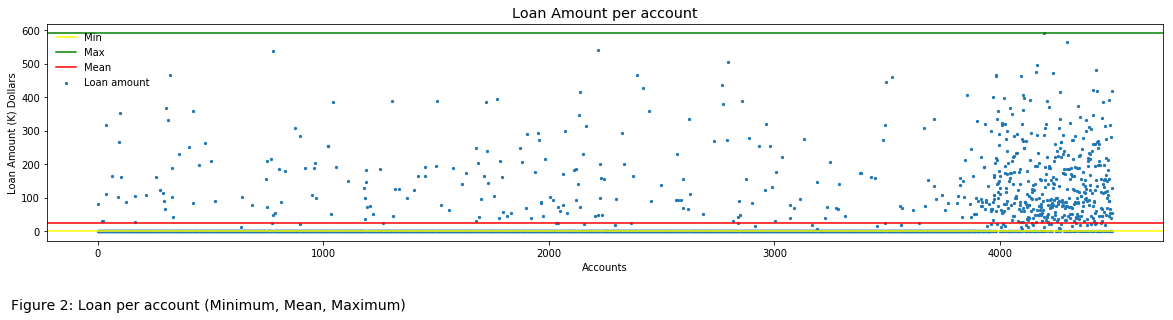

In [3]:
loan_amt = data_set[pd.notna(data_set['loan_amt'])].groupby(['account_id'])['loan_amt']

X = loan_amt.first().values / 1000

fig = plt.gcf()
fig.set_size_inches(20, 4)
ax = plt.subplot(111)

plt.scatter(np.arange(X.shape[0]), X, s=5, label= 'Loan amount')
plt.title('Loan Amount per account', fontsize='x-large')
plt.axhline(min(X), color='yellow', label='Min')
plt.axhline(max(X), color='green', label='Max')
plt.axhline(X.mean(), color='red', label='Mean')

legend = plt.legend(loc='upper left', fontsize='medium', framealpha=0)
plt.ylabel('Loan Amount (K) Dollars')
plt.xlabel('Accounts')

txt = 'Figure 2: Loan per account (Minimum, Mean, Maximum)'
fig.text(0.1, -0.1, txt, horizontalalignment='left', 
         verticalalignment='center', transform=ax.transAxes, fontdict= {'size': 14})

plt.show()


In **Figure 2: Loan per account** we can see the amount per loan grouped by account. At first sigth it is dificult to figure out a kind of relation among the amounts and the account_id's which has been order consecutively.

However we can find a kind of group among the last thousand account_id's. But the same amount in loans.

Also, it is noticeable that with this simple scatter plot some discordant points start emerging among the others.


**Payment Orders**

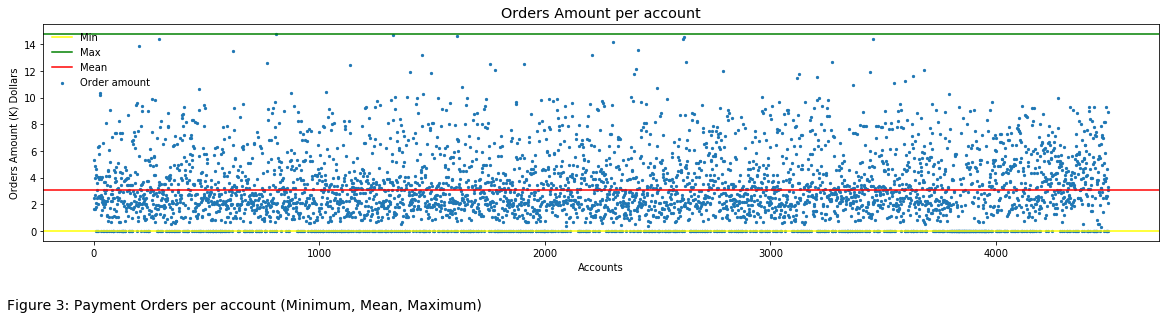

In [4]:
order_amt = data_set[pd.notna(data_set['order_amt'])].groupby(['account_id'])['order_amt']

X = order_amt.mean() / 1000

fig = plt.gcf()
fig.set_size_inches(20, 4)
ax = plt.subplot(111)

plt.scatter(np.arange(X.shape[0]), X, s=5, label='Order amount')
plt.title('Orders Amount per account', fontsize='x-large')
plt.axhline(min(X), color = 'yellow', label='Min')
plt.axhline(max(X), color = 'green', label='Max')
plt.axhline(X.mean(), color = 'red', label='Mean')

legend = plt.legend(loc='upper left', fontsize='medium', framealpha=0)
plt.ylabel('Orders Amount (K) Dollars')
plt.xlabel('Accounts')
txt = 'Figure 3: Payment Orders per account (Minimum, Mean, Maximum)'
fig.text(0.1, -0.1, txt, horizontalalignment='left', 
         verticalalignment='center', transform=ax.transAxes, fontdict= {'size': 14})

plt.show()

In **Figure 3: Payment Orders per account** we can see the amount per order grouped by account. As well as in the Figure 2, it is dificult to figure out a kind of relation among the amounts and the account_id's which has been order consecutively.

Here, in the Order plot, it is not identified any kind of group, pattern or relations in the set.

But, as well as in the Figure 2, here it is noticeable some discordant points.

**Transactions**

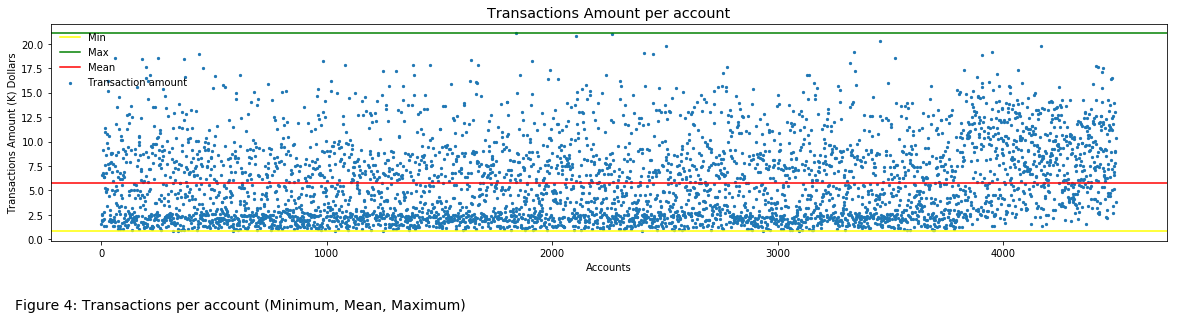

In [5]:
trans_amt = data_set[pd.notna(data_set['trans_amt'])].groupby(['account_id'])['trans_amt']

trans_grouped = trans.groupby(['account_id'])

X = trans_amt.mean() / 1000

fig = plt.gcf()
fig.set_size_inches(20, 4)
ax = plt.subplot(111)

plt.scatter(np.arange(X.shape[0]), X, s=5, label='Transaction amount')
plt.title('Transactions Amount per account', fontsize='x-large')
plt.axhline(min(X), color = 'yellow', label='Min')
plt.axhline(max(X), color = 'green', label='Max')
plt.axhline(X.mean(), color = 'red', label='Mean')
plt.ylabel('Transactions Amount (K) Dollars')

legend = plt.legend(loc='upper left', fontsize='medium', framealpha=0)
plt.ylabel('Transactions Amount (K) Dollars')
plt.xlabel('Accounts')
txt = 'Figure 4: Transactions per account (Minimum, Mean, Maximum)'
fig.text(0.1, -0.1, txt, horizontalalignment='left', 
         verticalalignment='center', transform=ax.transAxes, fontdict= {'size': 14})

plt.show()


In **Figure 4: Transactions per account** we can see the amount per order grouped by account. It is not noticeable patters, relations or groups either. But some outstanding points away from the mean.


However in Figure 2, Figure 3 and Figure 4, it is set 2 limits the maximun, the minimum and the mean. So, despite the no-relation found with this method, we can start figuring out how the data points, in this case, amounts of money, are distributed a long the accounts.

Let's see now, another point of view of the scatter plots: The Scatter Matrix.

/Users/luischapa/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead


Text(0.1,-0.1,'Figure 5: Operations Scatter Matrix Plot')

<Figure size 432x288 with 0 Axes>

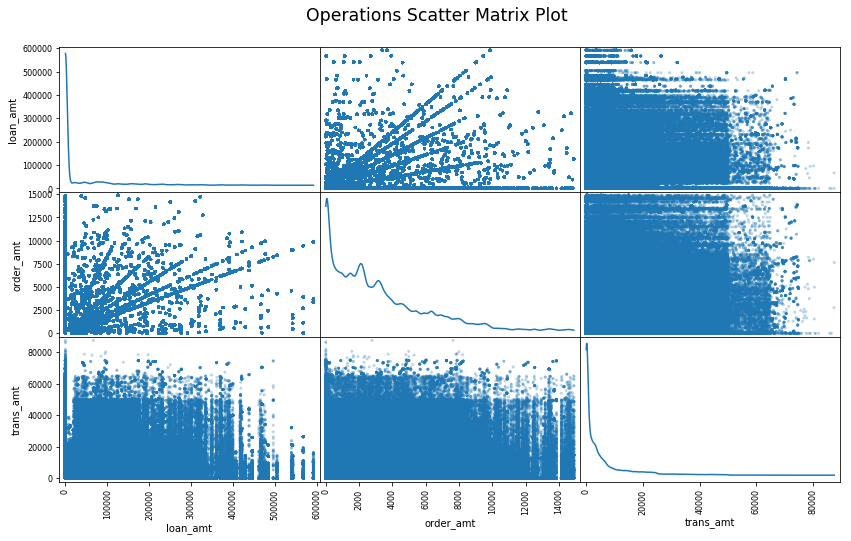

In [6]:
fig = plt.gcf()

scatter_set = data_set.loc[:,['loan_amt','order_amt','trans_amt']]
pd.scatter_matrix(scatter_set, alpha = 0.3, figsize = (14,8), diagonal = 'kde');
plt.suptitle('Operations Scatter Matrix Plot', x=0.5, y=0.95, ha='center', fontsize='xx-large')

txt = 'Figure 5: Operations Scatter Matrix Plot'
fig.text(0.1, -0.1, txt, horizontalalignment='left', 
         verticalalignment='center', transform=ax.transAxes, fontdict= {'size': 14})


**Figure 5 Operations Scatter Matrix Plot** shows that there is a group-related pattern of two operations: order and loan, and we can notice that transactions are totally unrelated to the others.

So, it seems that the more common algorithms are going to find hard the search for patterns. That's why we has propused two models for this investigation of patterns and novelties in this dataset: 

1. Benchmark Model, **PCA** (Principal Component Analysis) for selecting features and **GMM** (Gaussian Mixture Model) for grouping the previuos selected features.

2. Solution Model, the bet is for this model, it is a **Deep Autoencoder**, which is using neural networks to work.

More on this in the comming sections.

### 4. Benchmark model
---
As it was discussed at the begining of this report, The Bank has not labeled operations as fraud or normal so far. So, the we are helping them with this labeling process in order to detect likely fraudulent operation in advanced and act accordingly.

However The Bank managers have estimated a rule of thumb: one of a thousand operations must be investigate further. So if the dataset counts with: 

$$ 6471 (orders) + 1056320(transactions) + 682(loans) = 1,063,473 (operations)$$

then:

$$ 1,063,473 / 1000 = 1063 (novelties) $$

migth be identified for further investigation.

This sections is propusing a model, the Benchmark, whose result will be used to compare to a more robust model, the Solution model.

#### 4.1 Algorithms and techniques
---
The objective of this project is to find a way of detecting novelties on-time among the operations clients perform in The Bank. Such thing can be achieved setting a Threshold $T$ in order to label operations. After that, human-being intervention is needed to validate and adjust that threshold. 

The threshold $T$, in this approach, will be determined by the following technique:
1. Apply a PCA to the data set in order to select only the features that best describes the dataset.
2. Apply a GMM to the features previously selected in order to group features.
3. Measure the euclidean distance of each data point to each group center and set the maximun distance.
4. Reduce by a factor $\lambda$ this maximun distance and then establish the Threshold $T$.
5. By compare the Threshold $T$ to the max distance of each point to any of the centers, decide if it is beyond and should be marked as novelty.

#### 4.2 Preprocessing
---

In this section, a couple of preprocessing is applied to the data set. 

1. The cathegorical columns are changed to dummies.
2. The columns that hold monetary values, are log-tranformed in order to make the distributions less skewed.

In [7]:
#dummies
dummies_cols = ['disp_type','card_type','district_client','district_account','frequency','bank_to','order_k_symbol',
    'trans_k_symbol','trans_type','operation','status','duration']

data_set_transform = pd.get_dummies(data_set, dummy_na=True, columns = dummies_cols)

#Log
log_columns = ['loan_amt', 'payments', 'order_amt', 'trans_amt', 'balance']
for column in log_columns:
    X = data_set_transform[column]
    X = np.log(X)
    x_min = min([x if x > 0 else 0 for x in X])
    x_max = max(X)
    X = [(x - x_min) / (x_max - x_min) if x > 0 else 0 for x in X]
    data_set_transform[column] = X

cols_dummies = data_set_transform.columns.difference(new_order_columns)

data_set_input = pd.concat([pd.DataFrame(data_set_transform[log_columns]),
                            pd.DataFrame(data_set_transform[cols_dummies])],axis=1, sort=False)

/Users/luischapa/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log
/Users/luischapa/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in log


#### 4.3 Implementation
---
**PCA** or Principal Component Analysis is a statistical algorithm for dimensionality reduction by orthogonal transformation to a data set of possibly correlated variables that explain as much of the variability of the dataset.

In [8]:
#Set a random seed for reproducibility
np.random.seed(seed=0)

#PCA
from sklearn.decomposition import PCA

pca = PCA(n_components = 40, svd_solver = 'auto')
data_set_pca = pca.fit_transform(data_set_input)

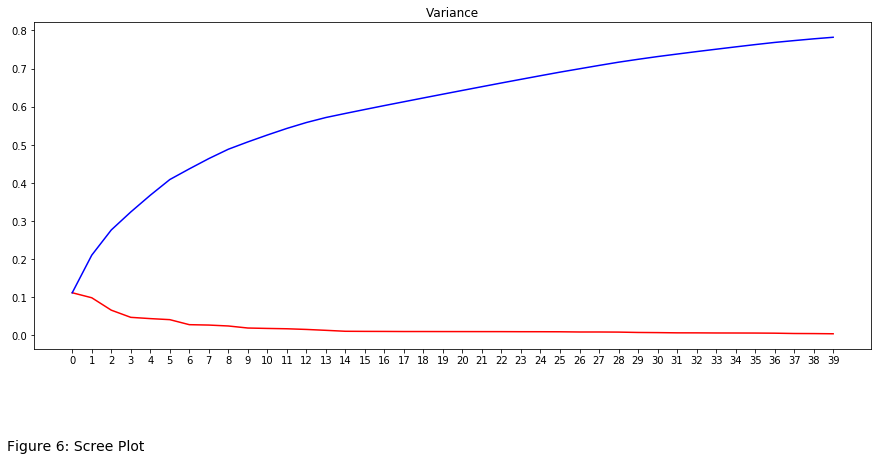

In [9]:
import matplotlib.ticker as ticker

size = len(pca.explained_variance_ratio_)

acc_variance_ratio = np.arange(size, dtype=np.float)
acc = 0
for i in range(size):
    acc += pca.explained_variance_ratio_[i]
    acc_variance_ratio[i] = acc

fig = plt.gcf()
fig.set_size_inches(15, 6)

ax = plt.subplot(1, 1, 1)
ax.plot(pca.explained_variance_ratio_,c = 'r')
ax.plot(acc_variance_ratio,c = 'b')
ax.set_xticks(np.arange(0,size))
plt.title('Variance')

txt = 'Figure 6: Scree Plot'
fig.text(0.1, -0.1, txt, horizontalalignment='left', 
         verticalalignment='center', transform=ax.transAxes, fontdict= {'size': 14})

plt.show()

In **Figure 6: Scree Plot** can be noticed an "elbow" by the component 3. So, by taking the first 3 components [0,1,2]  that are before this one accordingly to this graph is a good choice. Which is also convenient to make a 3D plot and keep going in visualize identifying novelties.

The total amount of variability explained by these 3 components is 27.64%. We have determined this is a good trade-off in between the amount of variability explained and the benefit of 3D plot we can get by taking these 3 Principal Components.

In [10]:
print('Variability explained: {:2.2f}%'.format(acc_variance_ratio[2]*100))

Variability explained: 27.64%


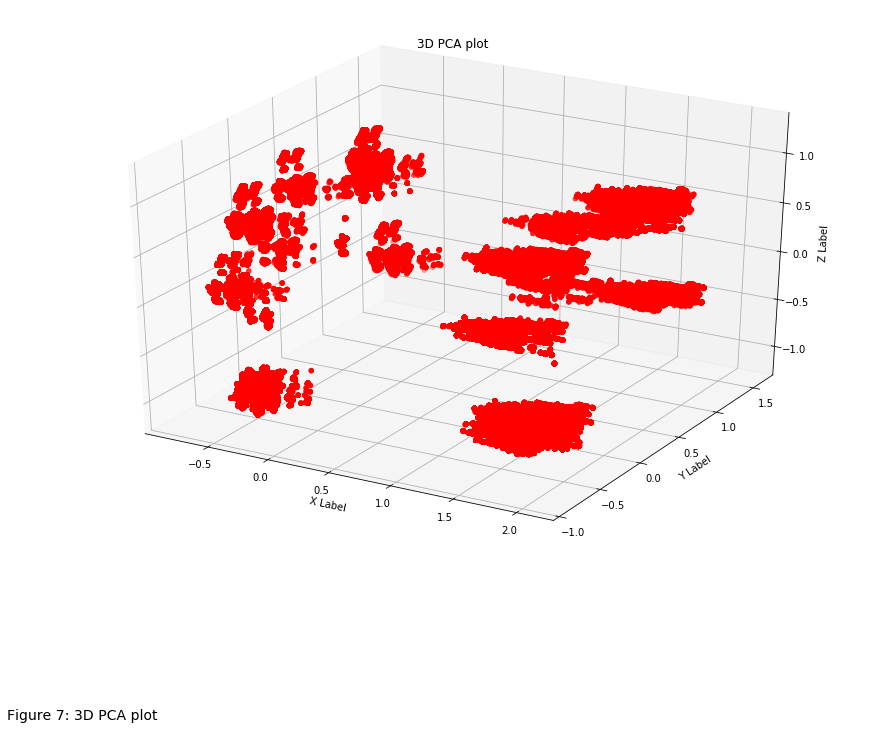

In [11]:
data_set_pca.shape

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
fig.set_size_inches(15, 10)
ax = fig.add_subplot(111, projection='3d')

plt.title('3D PCA plot')
ax.scatter(data_set_pca[:,0], data_set_pca[:,1], data_set_pca[:,2], c='r', marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

txt = 'Figure 7: 3D PCA plot'
fig.text(0.1, -0.1, txt, horizontalalignment='left', 
         verticalalignment='center', transform=ax.transAxes, fontdict= {'size': 14})

plt.show()

In **Figure 7: 3D PCA plot** we can visualize clusters, and novelties are noticed apart in the space, in other words points away from any of the clusters. Let's apply the algorithms to calculate mathematically those points.

**GMM** or Gaussian Mixture Model proposes that all data points belongs to one of the finite mixture of gaussians distributions with unknown parameters.

In [12]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import silhouette_score

#Take the 3 first components accordingly to Scree plot
data_set_gmm = data_set_pca[:,0:3]

#GMM
gmm = GaussianMixture(n_components = 2).fit(data_set_gmm)

In [13]:
### Calculate the all points all cluster max distance

#Euclidean Distance between to multidimensional points.
def distance(a,b):
    return np.sqrt(np.array([(a_i - b_i) ** 2 for a_i,b_i in zip(a,b)]).sum())

centers = gmm.means_

#Calculate each point and each center of the mixtures distance
dist_train = np.array([[distance(p, c) for c in centers] for p in data_set_gmm]) 

#Get the max distance for each center to one point
dist_max_cluster = dist_train.max(axis = 0)

#Get the maximun distance among all points and all centers
dist_max_all = dist_max_cluster.max()

#Get the max distance for each point to one center
dist_points_max = dist_train.max(axis = 1)


In [14]:
#Lamba proposed is 0.9, get all data points beyond that Threshold T
lambda_gmm = 0.9 

outlier_gmm = np.array([d > dist_max_all * lambda_gmm for d in dist_points_max])

print('For a Lambda = {:4.2f} Novelties detected: {}'.format(lambda_gmm, sum(outlier_gmm)))

For a Lambda = 0.90 Novelties detected: 244377


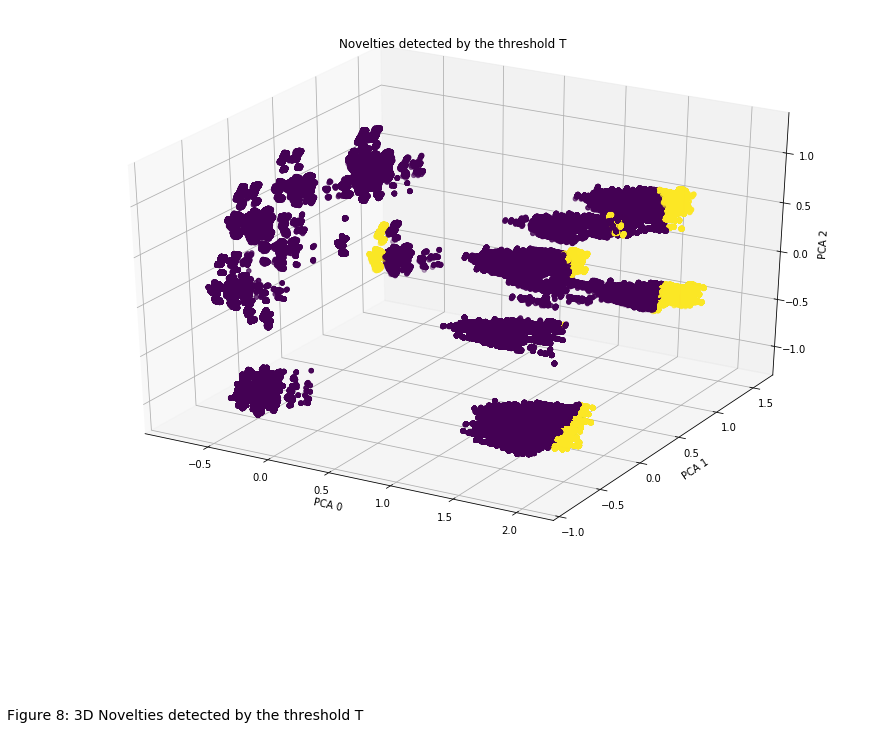

In [15]:
#Plot anomalies in 3D
fig = plt.figure()
fig.set_size_inches(15, 10)
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data_set_pca[:,0], data_set_pca[:,1], data_set_pca[:,2], c=outlier_gmm, marker='o')
plt.title('Novelties detected by the threshold T')

ax.set_xlabel('PCA 0')
ax.set_ylabel('PCA 1')
ax.set_zlabel('PCA 2')

txt = 'Figure 8: 3D Novelties detected by the threshold T'
fig.text(0.1, -0.1, txt, horizontalalignment='left', 
         verticalalignment='center', transform=ax.transAxes, fontdict= {'size': 14})

plt.show()


In **Figure 8: 3D Novelties detected by threshold** it is noticed a total of $244377$ data points classified and depicted as novelties by this model.

In [28]:
lambdas = np.array([0.7,0.8,0.9])

rows = data_set_input.shape[0]
cols = lambdas.size

outlier_gmm = np.ndarray(rows * cols, dtype=np.bool)
outlier_gmm = outlier_gmm.reshape(rows, cols)

#Lambdas
for i in range(cols):
    outlier_gmm[:, i] = np.array([d > dist_max_all * lambdas[i] for d in dist_points_max]).reshape(rows, 1)[:,0]
    print('For a Lambda = {:4.2f} Novelties detected: {}'.format(lambdas[i], sum(outlier_gmm[:, i])))

For a Lambda = 0.70 Novelties detected: 2231549
For a Lambda = 0.80 Novelties detected: 1597725
For a Lambda = 0.90 Novelties detected: 244377


#### 4.4 Refinement
---

The novelty detector was tested with 3 diferent values of the $\lambda$ parameters in order to stablish the threshold $T$.

As expected by increasing $\lambda$ the threshold $T$ gets narrower resulting in less number of novelties detected.

However, is was not enough for The Bank Managers as they told Machine Learning team, there are still too many novelties to be analyzed and labeled by humans ($ > \approx 1000$).

### 5. Solution Model
---
Once the Benchmark Model has shown up its results, let's propose a diferent approach, let's see this Solution Model which is using Deep Autoencoders to catch distant data points from the mean. 

The Benchmark Model only takes into account the 27.64% of the variability by selecting the Principal Components. This migth be enough, but in this approach, the model allows a more advanced technique by taking the whole set of features, this way a wider picture of the dataset is taken into account, thus making this approach smarter. So, the system is able to identify those novelties from non-linear related datasets (as shown in Figures 2,3 and 4) easier and more reliable.

> Zocca, Valentino, et.al. Python Deep Learning. Birmingham, UK. Pack Publishing LTD. April 2017. Chapter 9 'Anomalie Detection'

#### 5.1 Algorithms and Techniques
---
The Deep Autoencoders are layers of neural networks that copy the input data to the output. But in the middle, there is a layer that compress the most relevant features of the intput (Encode) into a latent representation $h$ and then reconstructs (Decode) from this latent representation to the data again fully fledged of all features $r$. Of course, the reconstructed data has some reconstruction error, and this parameters is going to be taken into account to label a datapoint as novelty. This is because the distant datapoints have a higher reconstruction error.

In **Figure 9: Arquitecture of Autoencoder** we can see the explanation above.
<img src="AutoEncoder.png">

I'd like to mention the source of my explanation and image about the Autoencoders:
> Nathan Hubens (February 25, 2018) Deep inside: Autoencoders [Blog post]. Retrieve from: https://towardsdatascience.com/deep-inside-autoencoders-7e41f319999f

So, this algorithms are apply as follow:
1. Train the Deep Autoencoder with the data_set.
2. Pass each data point through it and get the reconstruction error for each one.
3. Calculate the max reconstruction error.
4. Get the threshold $T$ by reducing the max reconstruction error by a $\lambda$ factor.
5. Compare each point reconstruction error to the Threshold $T$ and decide if it should be marked as novelty.


#### 5.2 Preprocessing
---

Recall from the Bechmark Model where a couple of preprocessing where applied, the same resulting tranformed dataset is going to be used here because the same preprocessing is valid for this Solution Model.

#### 5.3 Implementation
---

In [29]:
# The Autoencoder
import os
from keras.layers import Dense, Input, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint

input_size = data_set_input.shape[1]
hidden_size = 32
output_size = data_set_input.shape[1]

#Original data point
x = Input(shape=(input_size,))

#Dropout, avoid overfit
#Dropout(rate = 0.3, seed = 0)

# Encoder h = f(x)
h = Dense(hidden_size, activation='relu')(x)

# Decoder r = g(h)
r = Dense(output_size, activation='sigmoid')(h)

autoencoder = Model(input=x, output=r)
autoencoder.compile(optimizer='adam', loss='mse')

#Save the weights, save time training 
weights_filename = 'weights.best.from_scratch.hdf5'
if os.path.exists(weights_filename):
    autoencoder.load_weights(weights_filename)
else:
    checkpointer = ModelCheckpoint(filepath=weights_filename, 
                                   verbose=1, save_best_only=True)
    #Train the model
    autoencoder.fit(x=data_set_input,y=data_set_input, epochs=50, verbose=1,
                    validation_split=0.3, callbacks=[checkpointer])


/Users/luischapa/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 1570420 samples, validate on 673038 samples
Epoch 1/50
1570420/1570420 [==============================] - 166s 106us/step - loss: 0.0016 - val_loss: 0.0037

Epoch 00001: val_loss improved from inf to 0.00365, saving model to weights.best.from_scratch.hdf5
Epoch 2/50
1570420/1570420 [==============================] - 156s 99us/step - loss: 6.1666e-05 - val_loss: 0.0036

Epoch 00002: val_loss improved from 0.00365 to 0.00364, saving model to weights.best.from_scratch.hdf5
Epoch 3/50
1570420/1570420 [==============================] - 156s 99us/step - loss: 5.0378e-05 - val_loss: 0.0036

Epoch 00003: val_loss did not improve
Epoch 4/50
1570420/1570420 [==============================] - 156s 99us/step - loss: 4.6518e-05 - val_loss: 0.0036

Epoch 00004: val_loss improved from 0.00364 to 0.00358, saving model to weights.best.from_scratch.hdf5
Epoch 5/50
1570420/1570420 [==============================] - 156s 100us/step - loss: 4.5280e-05 - val_loss: 0.0036

Epoch 00005: val_loss impr

In [30]:
#Pass each data point through the model
pred = autoencoder.predict(x=data_set_input, verbose=0)

#Calculate the reconstruction error usgin the Euclidean distance distance(x,r)
loss = np.array([distance(p_hat, p) for p_hat, p in zip(pred, data_set_input.values)])

#Get the max reconstruction error among all he points
max_reconstruction_error = loss.max()

In [31]:
#Lamba proposed is 0.8, get all data points beyond that Threshold T
lambda_autoencoder = 0.8 

#Detect the novelty points.
outlier_autoencoder = np.array([l > max_reconstruction_error * lambda_autoencoder for l in loss])

print('For Lamda = {:4.2f} Novelties detected: {}'.format(lambda_autoencoder, sum(outlier_autoencoder)))

For Lamda = 0.80 Novelties detected: 3466


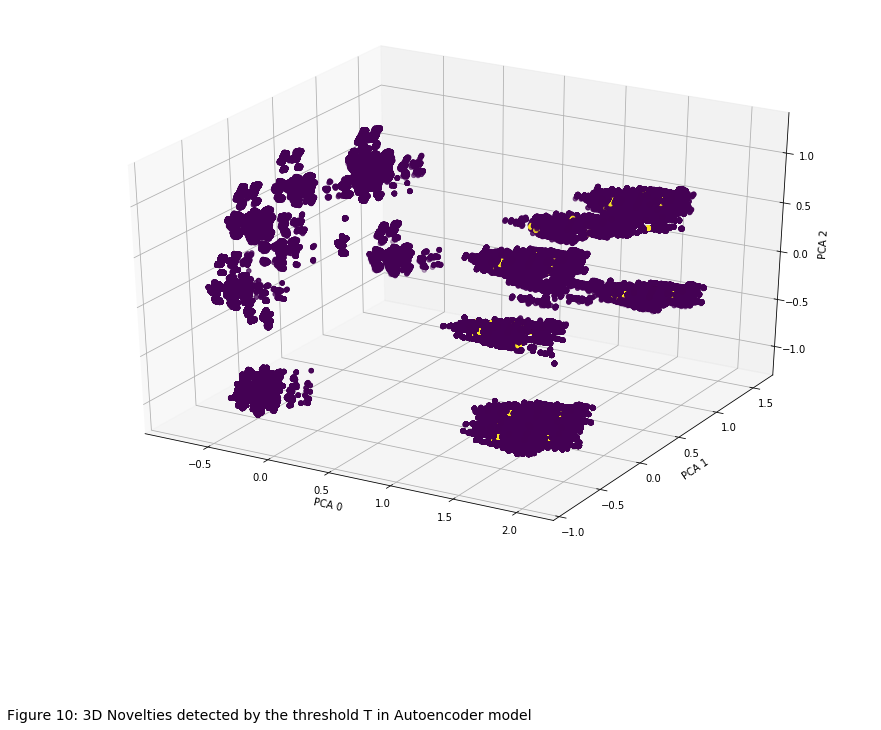

In [32]:
fig = plt.figure()
fig.set_size_inches(15, 10)
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data_set_pca[:,0], data_set_pca[:,1], data_set_pca[:,2], c=outlier_autoencoder, marker='o')

ax.set_xlabel('PCA 0')
ax.set_ylabel('PCA 1')
ax.set_zlabel('PCA 2')

txt = 'Figure 10: 3D Novelties detected by the threshold T in Autoencoder model'
fig.text(0.1, -0.1, txt, horizontalalignment='left', 
         verticalalignment='center', transform=ax.transAxes, fontdict= {'size': 14})

plt.show()

In **Figure 10 Novelties detected by threshold T in Autoencoder model**, we barely see the only 3466 novelties detected. This is a less than novelties detected by the GMM as this algorithm is much more precise.

In order to be able to graph a 3D plot like the one above, the PCA dataset with the first 3 principal components were used, but, depicting the points detected by the Autoencoder.

In [33]:
outlier_aut = np.ndarray(rows * cols, dtype=np.bool)
outlier_aut = outlier_aut.reshape(rows, cols)

#Lambdas
for i in range(cols):
    outlier_aut[:, i] = np.array([l > max_reconstruction_error * lambdas[i] for l in loss]).reshape(rows, 1)[:,0]
    print('For a Lambda = {:4.2f} Novelties detected: {}'.format(lambdas[i], sum(outlier_aut[:, i])))

For a Lambda = 0.70 Novelties detected: 21648
For a Lambda = 0.80 Novelties detected: 3466
For a Lambda = 0.90 Novelties detected: 300


#### 5.4 Refinement
---

As expected, by increasing the $\lambda$ parameters the threshold $T$ is narrower resulting in less number of novelties detected.

In this Solution model, The Bank Manager accepted the number of novelties detected because it is a more manageable number of novelties to be analyzed by humans and start labeling each one of them and established a solid grount truth.


### 6. Results.
---

#### 6.1 Model Evaluation and Validation
---

The topology of Deep Autoencoders is as big as the combinations among layers, filters and conextions can be done in between them. Because of computationally limitations the validation of them was limited to understand the purpose of some of them, the one choosen is described below:

1. The one choosen is the "Vanilla" one, which means it is the simplest topology one. 
2. It is only composed by the input layer with the same number of features in the dataset, the encoder with significant less size in order to let them learn the principal features, and the output layer with the same size as the number of features in the data set.
3. A dropout layer was added with a rate of 0.3, in order to avoid overfitting the dataset.

Also, three values of the $\lambda$ parameter were validated in both models, the explanation of that in the following section where comparing the two models is done.


In [34]:
rule_of_thumb = 1000
def set_lbl(s):
    lbls = []
    for i in range(len(s)):
        if s[i] <= rule_of_thumb:
            lbls.append('{:,} < 1K'.format(s[i]))
        else:
            lbls.append('{:,} > 1K'.format(s[i]))
    return lbls

sum_gmm = [sum(outlier_gmm[:, i]) for i in range(cols)][::-1]
sum_aut = [sum(outlier_aut[:, i]) for i in range(cols)][::-1]

lbl_gmm = set_lbl(sum_gmm)
lbl_aut = set_lbl(sum_aut)

lambdas_rev = lambdas[::-1]
pos = np.arange(cols)

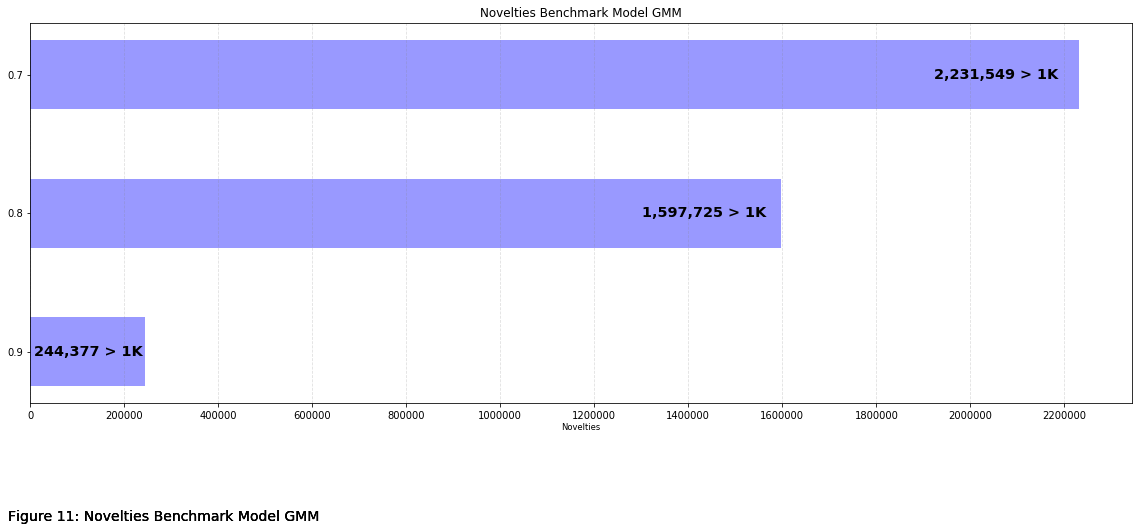

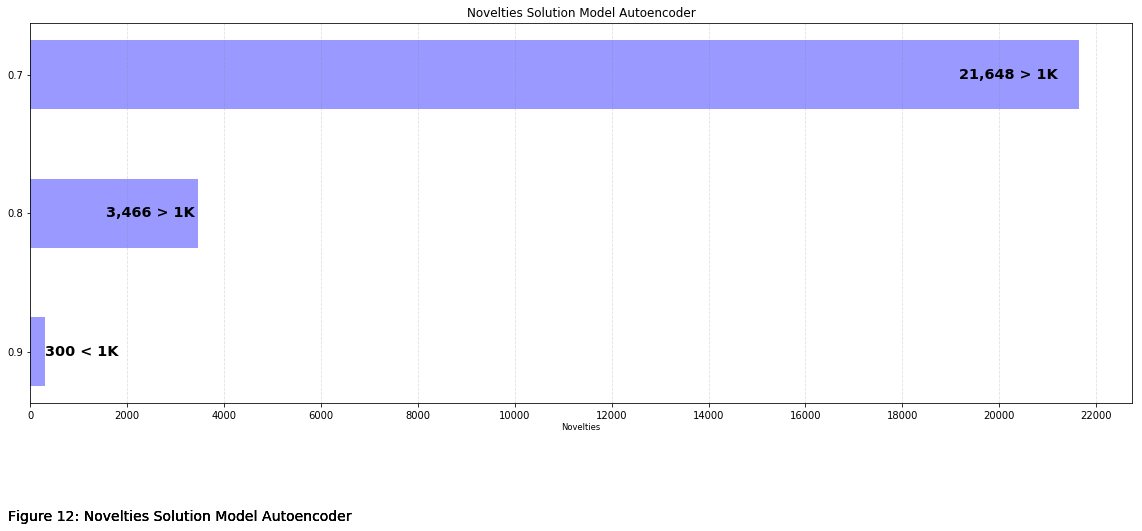

In [35]:
from matplotlib.ticker import MaxNLocator

bar_width = 0.05
opacity = 0.4

def plot_sums(title, sums, lbls, fig_txt):
    fig, ax1 = plt.subplots(figsize=(20, 7))
    fig.subplots_adjust(left=0.115, right=0.88)
    fig.canvas.set_window_title('NOVELTIES')

    rects = ax1.barh(pos, sums, align='center', height=0.5, color='b',alpha=opacity,
                     tick_label=lambdas_rev)
    ax1.set_title(title)

    ax1.xaxis.set_major_locator(MaxNLocator(15))
    ax1.xaxis.grid(True, linestyle='--', which='major',
                   color='grey', alpha=.25)

    x_label = ax1.text(.5, -.07, 'Novelties',horizontalalignment='center', size='small',
                    transform=ax1.transAxes)
    i=0
    for rect in rects:
        width = int(rect.get_width())
        rule = lbls[i]
        if sums[i] < 3000:
            xloc = width + 1
            align = 'left'
        else:
            xloc = 0.98 * width
            align = 'right'
        clr = 'black'
        
        yloc = rect.get_y() + rect.get_height() / 2.0
        label = ax1.text(xloc, yloc, rule, horizontalalignment=align, fontsize='x-large',
                         verticalalignment='center', color=clr, weight='bold',
                         clip_on=True)
        i += 1

        fig.text(0.1, -0.1, fig_txt, horizontalalignment='left', 
             verticalalignment='center', transform=ax.transAxes, fontdict= {'size': 14})


txt = 'Figure 11: Novelties Benchmark Model GMM'
plot_sums('Novelties Benchmark Model GMM', sum_gmm, lbl_gmm, txt)        
txt = 'Figure 12: Novelties Solution Model Autoencoder'
plot_sums('Novelties Solution Model Autoencoder', sum_aut, lbl_aut, txt)        

plt.show()

#### 6.2 Justification
---

The experimentation was done taking three values $[0.7,0.8,0.9]$ for the $\lambda$ parameter. With same value applied to both models we can notice the following:

In Figure 11: Novelties Benchmark Model GMM, the **Benchmark Model (GMM)** with $\lambda = [0.7]$ we notice that almost the entire data set was identied as novelty, which is not acceptable at all. Nor with $\lambda = [0.8]$, although it decreases the number of novelties identified, it is still not acceptable. The most significant approach was obtained with $\lambda = [0.9]$, although the number of novelties identified stills exceeds the rule of thumb set by the managers ($ \approx 1000$).

In Figure 12: Novelties Solution Model Autoencoder, the other hand, the **Solution Model (Autoencoder)** with $\lambda = [0.7]$ got a result greater than the rule of thumb. But the model got a much better result with the following two values $\lambda = [0.8,0.9]$ identifying less than the rule of thumb ($ \approx 1000$) for the both values.

So, the **Solution Model (Autoencoder)** gives The Bank manager a good start for further research in indentifying anomalies in thier client's operations and act accordingly.


### 7. Conclusion.
---

#### 7.1 Free-Form Visualization.
---
A long the implementation of the models, several 3D plots were depicted in order to see how the number of datapoints identified as novelties were changing along the algorithms were applied to the data set.

Figure 1...

#### 7.2 Reflection
---

This project was about a kind of identifying outstanding data points in a dataset, in order to start a baseline for label anomalies in the same dataset. Those anomalies are going to be used as warning against fraud in the 3 main operations The Bank serves to its clients.

Above all, The Bank Managers has established a rule of thumb accordingly to the industry past experience of 1 fraud operation among a thousand.

Taking that rule of thumb into account, a couple of models were proposed, in order to compare one against the other a determine the better performance of the one propused as Solution.

First model was a Gaussian Mixture Model who was the benchmark, the second was a Deep Autoencoder using neural networks. In both, in order to determine a novelty point, an Euclidean Distance was calculated and a Threshold propused in order to reach the number of novelties accordingly to the rule of thumb.

The interesting thing in this project was about having learnt how powerful and useful the neural networks and the such big different topologies could be to solve practical problems in a dataset.

I found hard to solve the problem, the fact that The Bank does not have a ground truth. Such important component for Machine Learning projects came to my mind as a foundamental piece to have a succesfull project.

However, the lacking of ground truth does not stop this approach that helped alot to The Bank in order to achieve their goal of protecting its clients.

#### 7.3 Improvements
---

Despite of the fact this is the first version of a fraud protection system, and the problem was partially solved. A more accurate Solution model should be trained once the ground truth is recorded.

Once that ground truth is recorded for a considerable period of time, a Deep Encoder Model with a similar topology can be trained to calculate new parameters and the parameters of this Solution Model can be used as bechnmark for that one. 

Also, in this project if we had understood how the **likelyhood** can be calculted, we have applied that formula for identify novelties.